In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import math
directory = 'C:/Users/U219200/OneDrive - IIASA/Projects/SM_AIRCO/data/'

In [19]:
df = pd.read_excel(directory+'global/all_gender_cleaned.xlsx')

In [20]:
df.tail()

,Unnamed: 0,ages_ranges,genders,scholarities,family_statuses,relationship_statuses,geo_locations,work_positions,income,dau_audience,mau_audience,publisher_platforms,age_min,country,interest_name
811,1,18-65+,male,NaN,NaN,NaN,RU,NaN,NaN,654302,790000,"[""facebook"", ""instagram""]",18,Russia,Air conditioning
812,2,18-65+,female,NaN,NaN,NaN,RU,NaN,NaN,0,910000,"[""facebook"", ""instagram""]",18,Russia,Air conditioning
813,3,18-65+,both,NaN,NaN,NaN,RU,NaN,NaN,33934483,60000000,"[""facebook"", ""instagram""]",18,Russia,no_interest
814,4,18-65+,male,NaN,NaN,NaN,RU,NaN,NaN,12049699,23000000,"[""facebook"", ""instagram""]",18,Russia,no_interest
815,5,18-65+,female,NaN,NaN,NaN,RU,NaN,NaN,21700799,36000000,"[""facebook"", ""instagram""]",18,Russia,no_interest


In [21]:
genders = ['female', 'male', 'both']
df = df.set_index('country')

## Penetration

In [22]:
# get the population and calculate penetration

df_country = pd.read_excel(directory+"fb keys/fb_countries_june21.xlsx")
df_country = df_country[['country', 'country_code', 'pop wb 2020']]
df_country = df_country.set_index('country')

In [23]:
df_country = df_country.dropna()

In [40]:
df.loc[(df['interest_name']=='no_interest')&(df['genders']=='both'),'population'] = df_country['pop wb 2020']

In [41]:
df['penetration'] = df['mau_audience'] / df['population']

In [42]:
df_pen = df['penetration'].dropna()

In [43]:
df_pen.to_excel(directory+'GlobalPenetration.xlsx')

In [44]:
df_pen[df_pen.values<0.2].shape

(35,)

In [24]:
for gender in genders:
    mau_int = df[(df['genders']==gender)&(df['interest_name']=='Air conditioning')]['mau_audience']
    mau_tot = df[(df['genders']==gender)&(df['interest_name']=='no_interest')]['mau_audience']
    new = mau_int / mau_tot
    df.loc[(df['genders']==gender)&(df['interest_name']=='Air conditioning'), 'ac_fr'] = new

# Visualize on the map

In [46]:
def geopandas_colorbar_same_height(f, ax, vmin, vmax, cmap):
    from matplotlib.colors import Normalize
    from matplotlib import cm
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)

    norm = Normalize(vmin=vmin, vmax=vmax)
    n_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
    n_cmap.set_array([])

    cbar = f.colorbar(n_cmap, cax=cax)
    cbar.ax.tick_params(labelsize=13) 

In [47]:
import geopandas as gpd

In [48]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [49]:
fb_countries = list(set(df.index))
map_countries = list(world.name)
fb_included = list(set(df[df.index.isin(world.name)].index))
fb_notincluded = [c for c in fb_countries if c not in fb_included]
fb_notincluded

['Central African Republic',
 'Czech Republic',
 'Dominican Republic',
 'Equatorial Guinea',
 'United States',
 'Mauritius',
 'Singapore',
 'Bosnia and Herzegovina',
 'South Sudan',
 'Bahrain']

In [50]:
world.loc[world.name == 'Czechia', 'name'] = 'Czech Republic'
world.loc[world.name == 'United States of America','name'] = 'United States'
world.loc[world.name == 'Bosnia and Herz.', 'name'] = 'Bosnia and Herzegovina'
world.loc[world.name == 'S. Sudan', 'name'] = 'South Sudan'
world.loc[world.name == 'Dominican Rep.', 'name'] = 'Dominican Republic'
world.loc[world.name == 'Somaliland', 'name'] = 'Somalia'

In [51]:
world = world.set_index('name')
world['ac_fr'] = 100 * df[(df['genders']=='both')&(df['interest_name']=='Air conditioning')]['ac_fr']

In [52]:
world['penetration'] = 100 * df_pen

In [53]:
world.head()

,pop_est,continent,iso_a3,gdp_md_est,geometry,ac_fr,penetration
name,,,,,,,
Fiji,920938,Oceania,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN
Tanzania,53950935,Africa,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",4.339623,8.872637
W. Sahara,603253,Africa,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
Canada,35623680,North America,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",11.428571,73.674055
United States,326625791,North America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",9.200000,75.876190


In [54]:
world.shape

(177, 7)

## Penentration rates

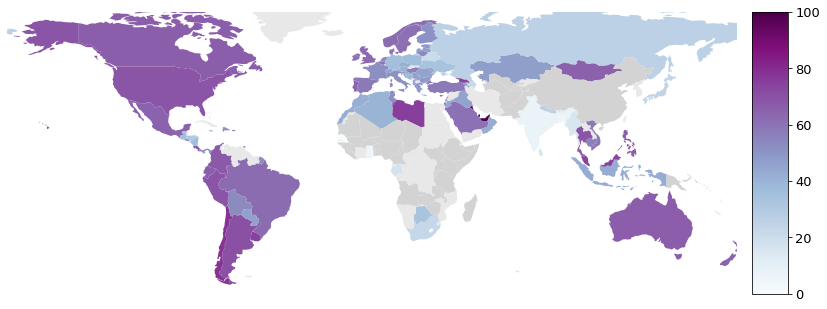

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(14,6)
ax.set_xlim([-175, 175])
ax.set_ylim([-60,75])
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

world[world['penetration']>=20].plot(ax=ax, column='penetration', cmap='BuPu')
world[world['penetration'].isna()].plot(ax=ax, color='lightgrey', alpha=0.5)
world[(world['penetration']>0)&(world['penetration']<20)].plot(ax=ax, color='lightgrey')

geopandas_colorbar_same_height(fig, ax, 0, 100, 'BuPu')

ax.set_axis_off()

#ax.set_title("Vegetarianism interest of the Facebook audience", fontsize=16)
#plt.savefig(directory+"World_veg_interest_Jan.png", dpi=300, bbox_inches='tight')
plt.show()

<AxesSubplot:ylabel='Frequency'>

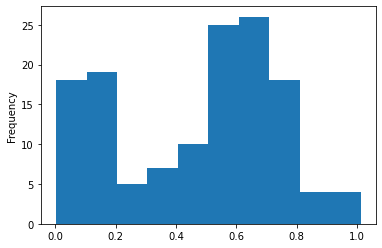

In [28]:
df_pen.plot(kind='hist')

In [56]:
# which countries have a low penetration?

dfplot = df[(df['genders']=='both')&(df['interest_name']=='no_interest')][['dau_audience', 'population', 'penetration']]
print(dfplot['penetration'].quantile([0.25, 0.5, 0.75]))

0.25    0.198322
0.50    0.557184
0.75    0.679293
Name: penetration, dtype: float64


In [57]:
dfplot['dau_audience'].quantile(.25)

916652.0

In [58]:
# to drop
dfd = dfplot[dfplot['penetration']<dfplot['penetration'].quantile(.25)]
#to_drop = dfd[dfd['dau_audience']<dfplot['dau_audience'].quantile(.5)]
to_drop = dfd[dfd['dau_audience']<dfplot['dau_audience'].quantile(.25)]


In [29]:
to_drop.to_excel(directory+'global/to_drop.xlsx')

In [59]:
world.loc[world['penetration'].isna(), 'included'] = 0.5
for index, row in world.iterrows():
    
    if index in to_drop.index.tolist():
        world.loc[index, 'included'] = 0
    elif row['included'] != 0.5:
        world.loc[index, 'included'] = 1

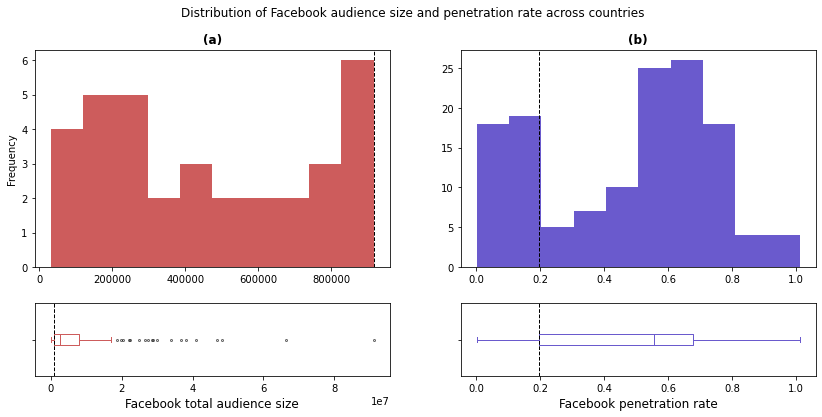

In [31]:
fig, axes = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 1]})

fig.set_size_inches(14,6)
plt.subplots_adjust(hspace=.25)

q_tot = dfplot['dau_audience'].dropna().quantile(.25)
q_pen = dfplot['penetration'].dropna().quantile(.25)

axes[0, 0] = dfplot[dfplot['dau_audience']<q_tot]['dau_audience'].plot(kind='hist', ax=axes[0,0], color='indianred')
axes[0, 1] = dfplot['penetration'].plot(kind='hist', ax=axes[0,1], color='slateblue')

flier = {'flierprops' : dict(marker='o', markerfacecolor='green', markersize=5,
                                                linestyle='none', alpha = .6)}
axes[1,0] = dfplot[dfplot['dau_audience']<1e+08]['dau_audience'].dropna().plot(kind='box', ax=axes[1,0], vert=False, 
                                                color='indianred', fontsize=10,
                                               flierprops = dict(marker='o', color='indianred', markersize=2,
                                                linestyle='none', alpha = .6))
axes[1,1] = dfplot['penetration'].dropna().plot(kind='box', ax=axes[1,1], vert=False, color='slateblue',)



axes[0,0].axvline(x=q_tot, c='black', lw=1, linestyle='--')
axes[0,1].axvline(x=q_pen, c='black', lw=1, linestyle='--')
axes[1,0].axvline(x=q_tot, c='black', lw=1, linestyle='--')
axes[1,1].axvline(x=q_pen, c='black', lw=1, linestyle='--')

axes[0, 1].set_ylabel('')
axes[1, 0].set_yticklabels([])
axes[1, 1].set_yticklabels([])

axes[0,0].set_title("(a)", fontweight='bold')
axes[0,1].set_title("(b)", fontweight='bold')

axes[1, 0].set_xlabel("Facebook total audience size", fontsize=12)
axes[1, 1].set_xlabel("Facebook penetration rate", fontsize=12)
plt.suptitle("Distribution of Facebook audience size and penetration rate across countries")
plt.savefig(directory+'airco_omittedcountries_hist.png', bbox_inches='tight')
plt.show()

In [60]:
dfplot['penetration'] = dfplot['penetration'] * 100

In [61]:
to_drop.index

Index(['Angola', 'Burkina Faso', 'Burundi', 'Benin',
       'Central African Republic', 'Guinea', 'Equatorial Guinea',
       'Guinea-Bissau', 'Liberia', 'Mauritania', 'Malawi', 'Niger',
       'Papua New Guinea', 'Rwanda', 'Sierra Leone', 'South Sudan', 'Chad',
       'Togo', 'Tajikistan', 'Turkmenistan', 'Zimbabwe'],
      dtype='object', name='country')

### Joint figure for penetration rates

In [62]:
import matplotlib.patches as mpatches

<ipython-input-37-274da9605170>:7: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(hspace=.25)


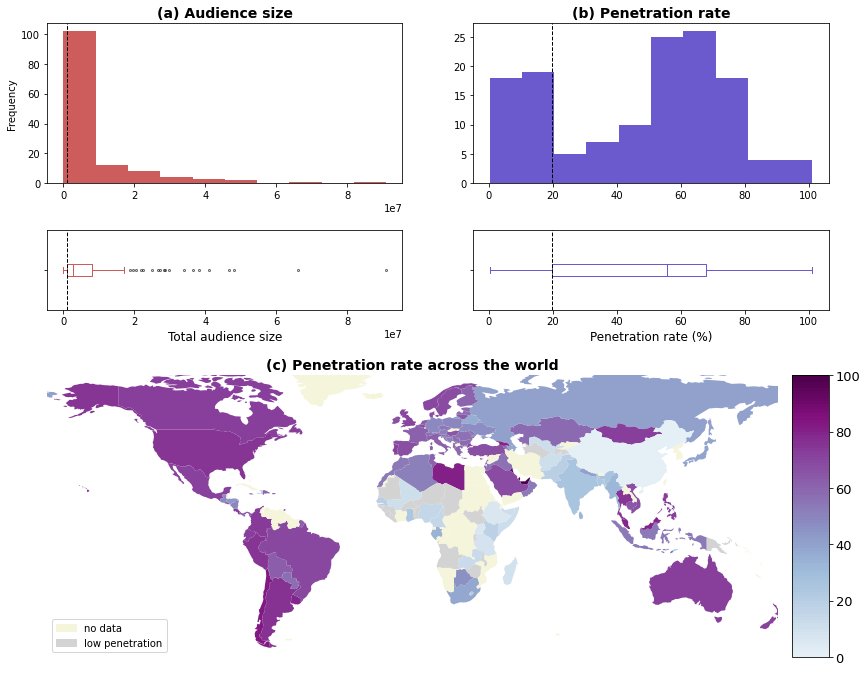

In [37]:
fig, axes = plt.subplots(3, 2, gridspec_kw={'height_ratios': [2, 1, 4]}, constrained_layout=True)
fig.set_size_inches(14,12)
gs = axes[2, 0].get_gridspec()
axbig = fig.add_subplot(gs[2, 0:])
axes[2,0].set_axis_off()
axes[2,1].set_axis_off()
plt.subplots_adjust(hspace=.25)
#plt.tight_layout()

# a and b - frequency and boxplots

q_tot = dfplot['dau_audience'].dropna().quantile(.25)
q_pen = dfplot['penetration'].dropna().quantile(.25)

axes[0, 0] = dfplot[dfplot['dau_audience']<1e+08]['dau_audience'].plot(kind='hist', ax=axes[0,0], color='indianred')
axes[0, 1] = dfplot['penetration'].plot(kind='hist', ax=axes[0,1], color='slateblue')

flier = {'flierprops' : dict(marker='o', markerfacecolor='green', markersize=5,
                                                linestyle='none', alpha = .6)}
axes[1,0] = dfplot[dfplot['dau_audience']<1e+08]['dau_audience'].dropna().plot(kind='box', ax=axes[1,0], vert=False, 
                                                color='indianred', fontsize=10,
                                               flierprops = dict(marker='o', color='indianred', markersize=2,
                                                linestyle='none', alpha = .6))
axes[1,1] = dfplot['penetration'].dropna().plot(kind='box', ax=axes[1,1], vert=False, color='slateblue',)

axes[0,0].axvline(x=q_tot, c='black', lw=1, linestyle='--')
axes[0,1].axvline(x=q_pen, c='black', lw=1, linestyle='--')
axes[1,0].axvline(x=q_tot, c='black', lw=1, linestyle='--')
axes[1,1].axvline(x=q_pen, c='black', lw=1, linestyle='--')

axes[0, 1].set_ylabel('')
axes[1, 0].set_yticklabels([])
axes[1, 1].set_yticklabels([])

axes[0,0].set_title("(a) Audience size", fontweight='bold', fontsize=14)
axes[0,1].set_title("(b) Penetration rate", fontweight='bold', fontsize=14)

axes[1, 0].set_xlabel("Total audience size", fontsize=12)
axes[1, 1].set_xlabel("Penetration rate (%)", fontsize=12)

# c - map
axbig.set_title("(c) Penetration rate across the world", fontweight='bold', fontsize=14)
axbig.set_xlim([-175, 175])
axbig.set_ylim([-60,75])
axbig.grid(False)
axbig.set_xticks([])
axbig.set_yticks([])


cmap = mpl.cm.BuPu(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

# included
world[world['included']==1].plot(ax=axbig, column='penetration', cmap=cmap)
# no data
world[world['included']==0.5].plot(ax=axbig, color='beige')
# dropped
world[world['included']==0].plot(ax=axbig, color='lightgrey')

geopandas_colorbar_same_height(fig, axbig, 0, 100, cmap)

axbig.set_axis_off()

# make legend with patches

beige = mpatches.Patch(color='beige', label='no data')
grey = mpatches.Patch(color='lightgrey', label='low penetration')

axbig.legend(handles=[beige, grey], ncol=1, loc='lower left')

plt.savefig(directory+'airco_penetration_1mDAU.png', bbox_inches='tight')

plt.show()


In [63]:
world[world['included']==1].shape

(113, 8)

In [40]:
world[world['included']==.5].shape

(45, 8)

In [28]:
world[world['included']==0].shape

(19, 8)

In [38]:
dfplot.to_excel(directory+'global/airco_penetration.xlsx')

In [87]:
import matplotlib as mpl
#cmap = mpl.cm.Blues(np.linspace(0,1,100))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])
cmap = mpl.cm.BuPu(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

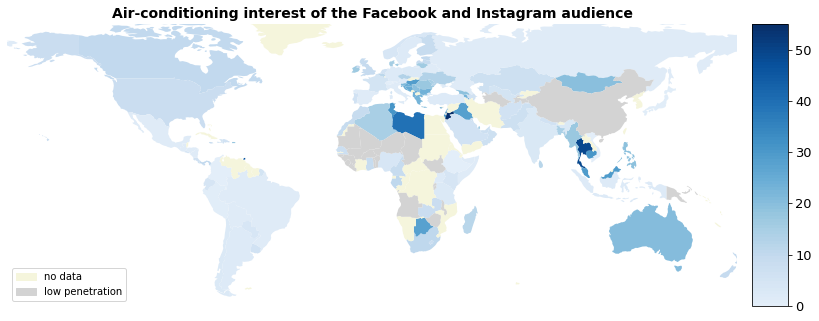

In [35]:

fig, ax = plt.subplots()
fig.set_size_inches(14,8)
ax.set_xlim([-175, 175])
ax.set_ylim([-60,75])
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("Air-conditioning interest of the Facebook and Instagram audience", fontweight='bold', fontsize=14)



# included
world[world['included']==1].plot(ax=ax, column='ac_fr', cmap=cmap)
# no data
world[world['included']==0.5].plot(ax=ax, color='beige')
# dropped
world[world['included']==0].plot(ax=ax, color='lightgrey')

geopandas_colorbar_same_height(fig, ax, 0, 55, cmap)

ax.set_axis_off()

# make legend with patches

beige = mpatches.Patch(color='beige', label='no data')
grey = mpatches.Patch(color='lightgrey', label='low penetration')

ax.legend(handles=[beige, grey], ncol=1, loc='lower left')

plt.savefig(directory+'airco_interest_1m_dau.png', bbox_inches='tight')


plt.show()

In [42]:
world['ac_fr'].max()

54.385964912280706

In [43]:
world['ac_fr'].min()

0.5

# Relation to gender, age and education across the world

- calculate ac_fr for age and education
- two more dfs for age and education
- violin plots color-coded by global south-north


## 1. calculate ac_fr for age and education

In [11]:
# alternatively

to_drop = pd.read_excel(directory+'global/to_drop.xlsx')
df_rel = pd.read_excel(directory+'global/allcountries_cleaned_relationship.xlsx')
df_rel = df_rel.set_index('country')
print(df_rel.shape)
df_rel = df_rel.drop(to_drop['country'], axis=0)
print(df_rel.shape)
relationships = ['married or living together', 'all ']
for rel in relationships:
    mau_int = df_rel[(df_rel['relationship_statuses']==rel)&(df_rel['interest_name']=='Air conditioning')]['mau_audience']
    mau_tot = df_rel[(df_rel['relationship_statuses']==rel)&(df_rel['interest_name']=='no_interest')]['mau_audience']
    new = mau_int / mau_tot
    print(rel, new)
    df_rel.loc[(df_rel['relationship_statuses']==rel)&(df_rel['interest_name']=='Air conditioning'), 'ac_fr'] = new
                

(540, 13)
(456, 13)
married or living together country
United Arab Emirates    0.342462
Afghanistan             0.154718
Albania                 0.559524
Armenia                 0.241166
Argentina               0.277576
                          ...   
Uzbekistan              0.326556
Vietnam                 0.256579
Kosovo                  0.597652
South Africa            0.305060
Zambia                  0.319227
Name: mau_audience, Length: 114, dtype: float64
all  country
United Arab Emirates    0.243119
Afghanistan             0.085513
Albania                 0.413143
Armenia                 0.180892
Argentina               0.185637
                          ...   
Uzbekistan              0.228571
Vietnam                 0.172156
Kosovo                  0.446147
South Africa            0.136095
Zambia                  0.162907
Name: mau_audience, Length: 114, dtype: float64


In [12]:
df_rel[df_rel['interest_name']=='Air conditioning'][['relationship_statuses', 'dau_audience', 'mau_audience', 'ac_fr']].to_excel(directory+'global/relationship_box.xlsx')

In [13]:
df_fam = pd.read_excel(directory+'global/allcountries_cleaned_family.xlsx')
df_fam = df_fam.set_index('country')
df_fam = df_fam.drop(to_drop['country'], axis=0)

familys = ['parents of 0-8 yrs old', "parents of 9-18 yrs old", 'all family']
for fam in familys:
    mau_int = df_fam[(df_fam['family_statuses']==fam)&(df_fam['interest_name']=='Air conditioning')]['mau_audience']
    mau_tot = df_fam[(df_fam['family_statuses']==fam)&(df_fam['interest_name']=='no_interest')]['mau_audience']
    new = mau_int / mau_tot
    df_fam.loc[(df_fam['family_statuses']==fam)&(df_fam['interest_name']=='Air conditioning'), 'ac_fr'] = new
    
df_fam[df_fam['interest_name']=='Air conditioning'][['family_statuses', 'dau_audience', 'mau_audience', 'ac_fr']].to_excel(directory+'global/family_box.xlsx')

In [25]:
df_age = pd.read_excel(directory+'global/global_age_cleaned.xlsx')
df_age = df_age.set_index('country')
ages = ['18-34', '35-64', '65-65+']

for age in ages:
    mau_int = df_age[(df_age['ages_ranges']==age)&(df_age['interest_name']=='Air conditioning')]['mau_audience']
    mau_tot = df_age[(df_age['ages_ranges']==age)&(df_age['interest_name']=='no_interest')]['mau_audience']
    new = mau_int / mau_tot
    #print(age, mau_int, mau_tot)
    df_age.loc[(df_age['ages_ranges']==age)&(df_age['interest_name']=='Air conditioning'), 'ac_fr'] = new

In [26]:
df_age[df_age['ac_fr']>1]

,Unnamed: 0,ages_ranges,genders,scholarities,family_statuses,relationship_statuses,geo_locations,work_positions,income,dau_audience,mau_audience,publisher_platforms,age_min,age_max,interest_name,ac_fr
country,,,,,,,,,,,,,,,,
United Arab Emirates,0,65-65+,both,NaN,NaN,NaN,AE,NaN,NaN,1432767,1700000,"[""facebook"", ""instagram""]",65,NaN,Air conditioning,13.076923
Afghanistan,1,65-65+,both,NaN,NaN,NaN,AF,NaN,NaN,654302,790000,"[""facebook"", ""instagram""]",65,NaN,Air conditioning,5.266667
Albania,2,65-65+,both,NaN,NaN,NaN,AL,NaN,NaN,0,910000,"[""facebook"", ""instagram""]",65,NaN,Air conditioning,11.973684
Armenia,3,65-65+,both,NaN,NaN,NaN,AM,NaN,NaN,33934483,60000000,"[""facebook"", ""instagram""]",65,NaN,Air conditioning,645.161290
Angola,4,65-65+,both,NaN,NaN,NaN,AO,NaN,NaN,12049699,23000000,"[""facebook"", ""instagram""]",65,NaN,Air conditioning,164.285714
Argentina,5,65-65+,both,NaN,NaN,NaN,AR,NaN,NaN,21700799,36000000,"[""facebook"", ""instagram""]",65,NaN,Air conditioning,15.652174


In [27]:
df_education = pd.read_excel(directory+'global/global_education_cleaned.xlsx')
df_education = df_education.set_index('country')
educations = list(set(df_education['scholarities']))

for edu in educations:
    mau_int = df_education[(df_education['scholarities']==edu)&(df_education['interest_name']=='Air conditioning')]['mau_audience']
    mau_tot = df_education[(df_education['scholarities']==edu)&(df_education['interest_name']=='no_interest')]['mau_audience']
    new = mau_int / mau_tot
    #print(new)
    df_education.loc[(df_education['scholarities']==edu)&(df_education['interest_name']=='Air conditioning'), 'ac_fr'] = new

In [47]:
df[df['interest_name']=='Air conditioning'][['genders', 'dau_audience', 'mau_audience', 'ac_fr']].to_excel(directory+'global/genders_box.xlsx')

In [48]:
df_age[df_age['interest_name']=='Air conditioning'][['ages_ranges', 'dau_audience', 'mau_audience', 'ac_fr']].to_excel(directory+'global/ages_box.xlsx')

In [49]:
df_education[df_education['interest_name']=='Air conditioning'][['scholarities', 'dau_audience', 'mau_audience', 'ac_fr']].to_excel(directory+'global/education_box.xlsx')

<AxesSubplot:ylabel='Frequency'>

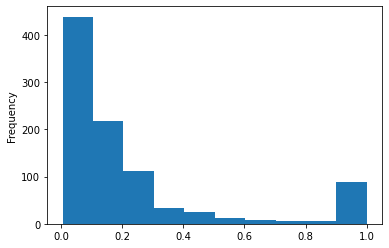

In [68]:
df_education['ac_fr'].plot(kind='hist')

In [109]:
educations

['7 Unspecified',
 '5 College grad or stdying higher',
 '1 High school stdent',
 '3 High school grad or stdying or some college',
 '6 Masters and Doctorate degree',
 '2 Some high school',
 '4 Professional or associate degree']

In [28]:
# GROUP THE EDUCATION
countries = list(set(df_education.index))
df_edu2 = pd.DataFrame(columns=['mau_audience', 'scholarities', 'interest_name', 'country'])
i=0
for cnt in countries:
    dfc = df_education.loc[cnt,:]
    for interest in ['no_interest', 'Air conditioning']:
        dfd = dfc[dfc['interest_name']==interest]
        for edu in ['1 Less than high school', '2 High school', '3 Bachelors', '4 Masters and PhD']:
            if edu.startswith("1"):
                dfe = dfd[dfd['scholarities']=='1 High school stdent']['mau_audience'] \
                    + dfd[dfd['scholarities']=='2 Some high school']['mau_audience']
            elif edu.startswith("2"):
                dfe = dfd[dfd['scholarities']=='3 High school grad or stdying or some college']['mau_audience']
            elif edu.startswith("3"):
                dfe = dfd[dfd['scholarities']=='4 Professional or associate degree']['mau_audience']\
                        + dfd[dfd['scholarities']=='5 College grad or stdying higher']['mau_audience']
            elif edu.startswith("4"):
                dfe = dfd[dfd['scholarities']=='6 Masters and Doctorate degree']['mau_audience']

            
            
            df_edu2.loc[i, 'mau_audience'] = dfe.values[0]
            df_edu2.loc[i, 'country'] = cnt
            df_edu2.loc[i, 'scholarities'] = edu
            df_edu2.loc[i,'interest_name'] = interest
            i += 1



In [29]:
df_edu2 = df_edu2.set_index('country')
educations2 = list(set(df_edu2['scholarities']))

for edu in educations2:
    mau_int = df_edu2[(df_edu2['scholarities']==edu)&(df_edu2['interest_name']=='Air conditioning')]['mau_audience']
    mau_tot = df_edu2[(df_edu2['scholarities']==edu)&(df_edu2['interest_name']=='no_interest')]['mau_audience']
    new = mau_int / mau_tot
    #print(new)
    df_edu2.loc[(df_edu2['scholarities']==edu)&(df_edu2['interest_name']=='Air conditioning'), 'ac_fr'] = new

In [30]:
df_edu2 = df_edu2.astype({'ac_fr': 'float'})

In [31]:
df_edu2.tail()

,mau_audience,scholarities,interest_name,ac_fr
country,,,,
Thailand,800000,4 Masters and PhD,no_interest,NaN
Thailand,1470000,1 Less than high school,Air conditioning,0.392000
Thailand,4400000,2 High school,Air conditioning,0.494382
Thailand,6111000,3 Bachelors,Air conditioning,0.554638
Thailand,530000,4 Masters and PhD,Air conditioning,0.662500


In [25]:
df_edu2[df_edu2['interest_name']=='Air conditioning'][['scholarities', 'mau_audience', 'ac_fr']].to_excel(directory+'global/education_box_grouped.xlsx')

<AxesSubplot:ylabel='Frequency'>

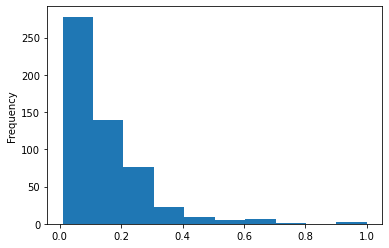

In [225]:
df_edu2['ac_fr'].plot(kind='hist')

In [32]:
df_genderb = df[df['interest_name']=='Air conditioning'][['genders', 'ac_fr']]
df_genderb = df_genderb[~df_genderb.index.isin(to_drop.index)]
df_ageb = df_age[df_age['interest_name']=='Air conditioning'][['ages_ranges', 'ac_fr']]

df_ageb = df_ageb[df_ageb['ac_fr']<=1]
df_ageb = df_ageb[~df_ageb.index.isin(to_drop.index)]
#df_edub = df_education[df_education['interest_name']=='Air conditioning'][['scholarities', 'ac_fr']]
df_edub = df_edu2[df_edu2['interest_name']=='Air conditioning'][['scholarities', 'ac_fr']]
df_edub = df_edub[~df_edub.index.isin(to_drop.index)]

In [33]:
df_genderb = df[df['interest_name']=='Air conditioning'][['genders', 'ac_fr']]
df_genderb = df_genderb[~df_genderb.index.isin(to_drop.index)]

In [36]:
df_relb = df_rel[df_rel['interest_name']=='Air conditioning'][['relationship_statuses', 'ac_fr']]
df_relb = df_relb[~df_relb.index.isin(to_drop.index)]
df_famb = df_fam[df_fam['interest_name']=='Air conditioning'][['family_statuses', 'ac_fr']]
df_famb = df_famb[~df_famb.index.isin(to_drop.index)]

In [34]:
len(list(set(df_edub.index)))

135

In [37]:
# add a global nort- south tag to all dfs
df_regions = pd.read_excel(directory+'global/regions.xlsx')
df_regions = df_regions.set_index('name')

In [38]:
df_genderb['region'] = df_regions['tag']
df_ageb['region'] = df_regions['tag']
df_edub['region'] = df_regions['tag']
df_relb['region'] = df_regions['tag']
df_famb['region'] = df_regions['tag']

In [78]:
df_ageb.tail()

,ages_ranges,ac_fr,region
country,,,
Uzbekistan,35-64,0.130000,north
Vietnam,35-64,0.017083,south
Kosovo,35-64,0.277778,north
South Africa,35-64,0.147692,south
Zambia,35-64,0.124490,south


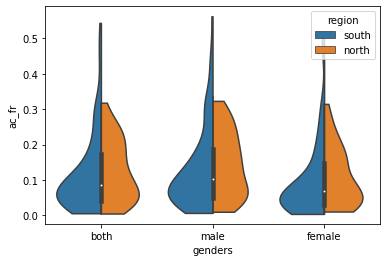

In [63]:
#ax = sns.swarmplot(x="genders" ,y="ac_fr", data=df_genderb)
ax = sns.violinplot(x="genders" ,y="ac_fr", data=df_genderb, cut=0, hue='region', split=True)
#ax = sns.swarmplot(x="genders" ,y="ac_fr", data=df_genderb, 
#                   color="lightgrey", edgecolor="grey", ax=ax, hue='region', split=True)

#to do add mean etc annotations 

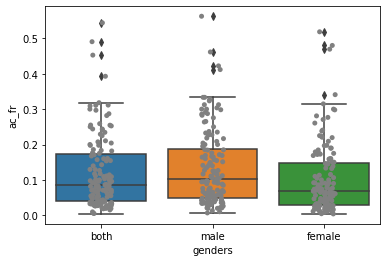

In [45]:
ax = sns.boxplot(x="genders" ,y="ac_fr", data=df_genderb)
ax = sns.stripplot(x="genders" ,y="ac_fr", data=df_genderb, 
                   color="grey", edgecolor="gray", ax=ax)

In [79]:
df_genderb['ac_fr'] = 100 * df_genderb['ac_fr']
df_ageb['ac_fr'] = 100 * df_ageb['ac_fr']
df_edub['ac_fr'] = 100 * df_edub['ac_fr']
df_famb['ac_fr'] = 100 * df_famb['ac_fr']
df_famb['ac_fr'] = 100 * df_famb['ac_fr']

In [81]:
df_edub = df_edub.sort_index()

In [82]:
df_edub.loc['United Kingdom',]

,scholarities,ac_fr,region
country,,,
United Kingdom,3 Bachelors,13.067353,north
United Kingdom,1 Less than high school,11.849315,north
United Kingdom,2 High school,13.043478,north
United Kingdom,4 Masters and PhD,8.727273,north


In [83]:
from matplotlib.collections import PolyCollection
def patch_violinplot():
    ax = plt.gca()
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_edgecolor('white')

In [39]:
# df of all statistical values

df_stat = pd.DataFrame()
i=0
att_dic = {'genders' : df_genderb,
          'ages_ranges' : df_ageb,
          'scholarities' : df_edub,
          'relationship_statuses' : df_relb,
           'family_statuses' : df_famb
          }
for attribute, dfd in att_dic.items():
    att_list = list(set(dfd[attribute]))
    for region in ['north', 'south', 'all']:
        if region == 'all':
            dfs = dfd
        else:
            dfs = dfd[dfd['region']==region]
        for atti in att_list:
            df_stat.loc[i, 'attribute'] = attribute
            df_stat.loc[i, 'range'] = atti
            df_stat.loc[i, 'region'] = region
            df_stat.loc[i, 'mean'] = dfs[dfs[attribute]==atti]['ac_fr'].mean()
            df_stat.loc[i, 'median'] = dfs[dfs[attribute]==atti]['ac_fr'].median()
            df_stat.loc[i, 'q25'] = dfs[dfs[attribute]==atti]['ac_fr'].quantile(q=.25)
            df_stat.loc[i, 'q75'] = dfs[dfs[attribute]==atti]['ac_fr'].quantile(q=.75)
            df_stat.loc[i, 'std'] = dfs[dfs[attribute]==atti]['ac_fr'].std()
            df_stat.loc[i, 'n'] = dfs[dfs[attribute]==atti]['ac_fr'].shape[0]
        
            i += 1
        
        
    



In [40]:
df_stat.head()

,attribute,range,region,mean,median,q25,q75,std,n
0,genders,female,north,0.108953,0.084615,0.041000,0.171875,0.080795,49.0
1,genders,male,north,0.147791,0.140541,0.065169,0.226667,0.092135,49.0
2,genders,both,north,0.128413,0.109091,0.053535,0.200000,0.085888,49.0
3,genders,female,south,0.095666,0.058929,0.027361,0.112756,0.107171,87.0
4,genders,male,south,0.126497,0.091667,0.045903,0.166900,0.113688,87.0


In [41]:
df_stat.to_excel(directory+'global/stats_v2.xlsx')

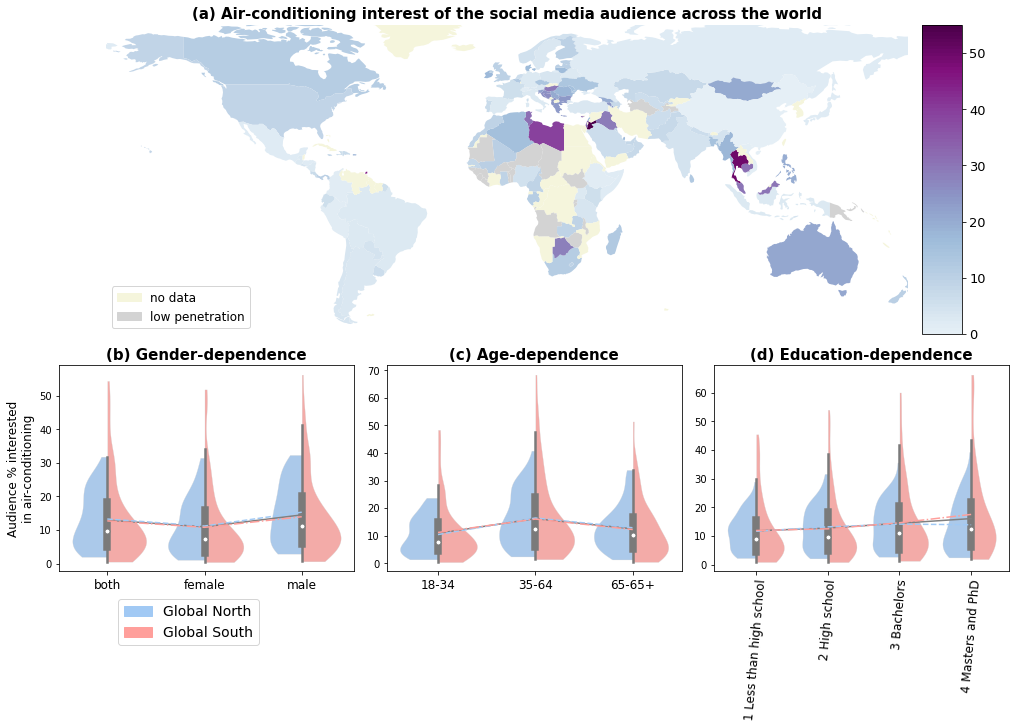

In [88]:
fig, axes = plt.subplots(2, 3, gridspec_kw={'height_ratios': [3,2]}, constrained_layout=True)
fig.set_size_inches(14,10)
gs = axes[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, 0:])
for i in range(3):
    axes[0,i].set_axis_off()

#axbig.set_axis_off()
#plt.subplots_adjust(hspace=.25)
#plt.tight_layout()


# a - map
axbig.set_title("(a) Air-conditioning interest of the social media audience across the world", fontweight='bold', fontsize=15)
axbig.set_xlim([-175, 175])
axbig.set_ylim([-60,75])
axbig.grid(False)
axbig.set_xticks([])
axbig.set_yticks([])

# included
world[world['included']==1].plot(ax=axbig, column='ac_fr', cmap=cmap)
# no data
world[world['included']==0.5].plot(ax=axbig, color='beige')
# dropped
world[world['included']==0].plot(ax=axbig, color='lightgrey')

geopandas_colorbar_same_height(fig, axbig, 0, 55, cmap)

axbig.set_axis_off()

# make legend with patches

beige = mpatches.Patch(color='beige', label='no data')
grey = mpatches.Patch(color='lightgrey', label='low penetration')

axbig.legend(handles=[beige, grey], ncol=1, loc='lower left', fontsize=12)

color_dic = {'north' : sns.color_palette('pastel')[0],
             'south' : sns.color_palette('pastel')[3]}


# (a) gender 
df_genderb = df_genderb.sort_values(['region', 'genders'])
axes[1,0] = sns.violinplot(x="genders" ,y="ac_fr", data=df_genderb, cut=0, hue='region', split=True, palette=color_dic, 
                           ax=axes[1,0], linewidth=2.5, inner='box')
axes[1,0].set_ylabel("Audience % interested\nin air-conditioning", fontsize=12)
axes[1,0].set_title("(b) Gender-dependence", fontweight='bold', fontsize=15)
axes[1,0].set_xlabel("")
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), fontsize=12)
for art in axes[1,0].get_children():
    if isinstance(art, PolyCollection):
        art.set_edgecolor('lightgrey')
        art.set_linewidth(0.25)

xs = [0, 1, 2]
ys_n = []
ys_s = []
ys = []
for gender in ['both', 'female', 'male']:
    ys.append(df_stat[(df_stat['attribute']=='genders')&(df_stat['range']==gender)&(df_stat['region']=='all')]['mean'])
    ys_n.append(df_stat[(df_stat['attribute']=='genders')&(df_stat['range']==gender)&(df_stat['region']=='north')]['mean'])
    ys_s.append(df_stat[(df_stat['attribute']=='genders')&(df_stat['range']==gender)&(df_stat['region']=='south')]['mean'])
    
axes[1,0].plot(xs, ys, color='grey', linestyle='-')
axes[1,0].plot(xs, ys_n, color=color_dic['north'], linestyle='--')
axes[1,0].plot(xs, ys_s, color=color_dic['south'], linestyle='-.')

#axes[1,0].set_ylim([0,50])

# (b) age
df_ageb = df_ageb.sort_values(['region', 'ages_ranges'])
axes[1,1] = sns.violinplot(x="ages_ranges" ,y="ac_fr", data=df_ageb, cut=0, hue='region', split=True, palette=color_dic, 
                           ax=axes[1,1], linewidth=2.5, inner='box')
axes[1,1].set_ylabel("", fontsize=12)
axes[1,1].set_title("(c) Age-dependence", fontweight='bold', fontsize=15)
axes[1,1].set_xlabel("")
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), fontsize=12)
for art in axes[1,1].get_children():
    if isinstance(art, PolyCollection):
        art.set_edgecolor('lightgrey')
        art.set_linewidth(0.25)

axes[1,1].legend([],[], frameon=False)
xs = [0, 1, 2]
ys_n = []
ys_s = []
ys = []
for age in ages:
    ys.append(df_stat[(df_stat['attribute']=='ages_ranges')&(df_stat['range']==age)&(df_stat['region']=='all')]['mean'])
    ys_n.append(df_stat[(df_stat['attribute']=='ages_ranges')&(df_stat['range']==age)&(df_stat['region']=='north')]['mean'])
    ys_s.append(df_stat[(df_stat['attribute']=='ages_ranges')&(df_stat['range']==age)&(df_stat['region']=='south')]['mean'])
    
axes[1,1].plot(xs, ys, color='grey', linestyle='-')
axes[1,1].plot(xs, ys_n, color=color_dic['north'], linestyle='--')
axes[1,1].plot(xs, ys_s, color=color_dic['south'], linestyle='-.')

#axes[1,1].set_ylim([0,50])

# (c) education
df_edub = df_edub.sort_values(['region', 'scholarities'])
axes[1,2] = sns.violinplot(x="scholarities", y="ac_fr", data=df_edub, cut=0, hue='region', split=True, palette=color_dic, 
                           ax=axes[1,2], linewidth=2.5, inner='box')
axes[1,2].set_ylabel("", fontsize=12)
axes[1,2].set_title("(d) Education-dependence", fontweight='bold', fontsize=15)
axes[1,2].set_xlabel("")
axes[1,2].set_xticklabels(axes[1,2].get_xticklabels(), rotation=85, fontsize=12)
for art in axes[1,2].get_children():
    if isinstance(art, PolyCollection):
        art.set_edgecolor('lightgrey')
        art.set_linewidth(0.25)
axes[1,2].legend([],[], frameon=False)

xs = [0, 1, 2, 3]
ys_n = []
ys_s = []
ys = []
for edu in ['1 Less than high school', '2 High school', '3 Bachelors', '4 Masters and PhD']:
    ys.append(df_stat[(df_stat['attribute']=='scholarities')&(df_stat['range']==edu)&(df_stat['region']=='all')]['mean'])
    ys_n.append(df_stat[(df_stat['attribute']=='scholarities')&(df_stat['range']==edu)&(df_stat['region']=='north')]['mean'])
    ys_s.append(df_stat[(df_stat['attribute']=='scholarities')&(df_stat['range']==edu)&(df_stat['region']=='south')]['mean'])
    
axes[1,2].plot(xs, ys, color='grey', linestyle='-')
axes[1,2].plot(xs, ys_n, color=color_dic['north'], linestyle='--')
axes[1,2].plot(xs, ys_s, color=color_dic['south'], linestyle='-.')

#axes[1,2].set_ylim([0,50])

# legend for noth-south


blue = mpatches.Patch(color= sns.color_palette('pastel')[0], label='Global North')
pink = mpatches.Patch(color=sns.color_palette('pastel')[3], label='Global South')

axes[1,0].legend(handles=[blue, pink], ncol=1, fontsize=14, bbox_to_anchor=(0.2, -0.6, 0.5, 0.5))

plt.savefig(directory+'global/airco_interest_with_mean_lines.png', bbox_inches='tight', dpi=300)

plt.show()

In [218]:
df_genderb['ac_fr'].max()

56.25

In [219]:
df_ageb['ac_fr'].max()

76.92307692307693

In [220]:
df_edub['ac_fr'].max()

100.0

In [91]:
world = world.sort_values(by=['ac_fr'], axis=0, ascending=False)



In [97]:
df_genderb.head()

,genders,ac_fr,region
country,,,
Albania,both,24.375000,north
Armenia,both,24.117647,north
Austria,both,3.617021,north
Australia,both,21.052632,north
Azerbaijan,both,7.948718,north


In [98]:
dfd = world[world['included']==1][['ac_fr', 'penetration']].head(20)
northc = list(set(df_genderb[df_genderb['region']=='north'].index))
southc = list(set(df_genderb[df_genderb['region']=='south'].index))
for index, row in dfd.iterrows():
    if index in northc:
        dfd.loc[index, 'region'] = 'north'
    elif index in southc:
        dfd.loc[index, 'region'] = 'south'

In [99]:
dfd[dfd['region'].isna()]

,ac_fr,penetration,region
name,,,


In [94]:
dfd.loc['Burkina Faso', 'region'] = 'south'

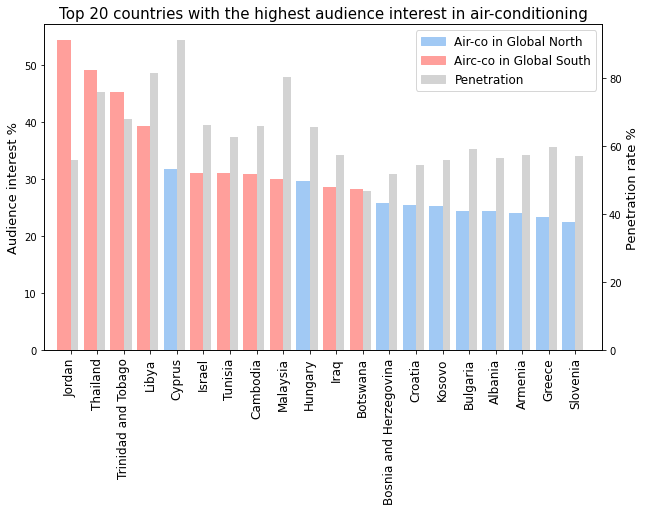

In [100]:
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
ax2 = ax.twinx()
dfd['ac_fr'].plot(kind='bar', ax=ax, color=[color_dic[i] for i in dfd['region']], position=1, width=0.5)
dfd['penetration'].plot(kind='bar', ax=ax2, position=0, color='lightgrey', width=0.3)
ax.set_xlim([-1, 20])
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_ylabel("Audience interest %", fontsize=13)
ax2.set_ylabel("Penetration rate %", fontsize=13)
ax.set_title("Top 20 countries with the highest audience interest in air-conditioning", fontsize=15)

blue = mpatches.Patch(color= color_dic['north'], label='Air-co in Global North')
red = mpatches.Patch(color= color_dic['south'], label='Airc-co in Global South')
grey = mpatches.Patch(color='lightgrey', label='Penetration')

ax.legend(handles=[blue, red, grey], ncol=1, fontsize=12, loc='upper right')


plt.savefig(directory+'global/top20.png', dpi=300, bbox_inches='tight')
plt.show()